In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
data = pd.read_csv('maternal_health_risk.csv')
print(data.head())

# Part 1: Data Exploration
## Display summary statistics
print(data.describe())

## Check for missing values
print(data.isna().sum())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    9

**What are we looking at?**

We are looking at data for maternal health risk. We have 1014 observation pairs with no missing data. The data has 7 features: Age,  SystolicBP,  DiastolicBP,    BS,  BodyTemp,  HeartRate, and  RiskLevel.

Of these, RiskLevel is qualitative. Our categorization model will predict this value.

We checked for reasonable averages and variations within our features to look for anything surprising. We noticed a minimum heart rate of 7 which seemed extreme or potentially a flawed measurement. Otherwise everything was within expectations.

Notably our average age is 29.87. According to Pew Research the average age of first pregnancy in the US is 27.3. For our purposes, we felt this was acceptable. However, it is valuable to note because it may help interpret the validity of our results. For example, this may lead to small limitations in evaluating maternal health risk before a patient's first pregnancy.






Low risk patients: 406
Mid risk patients: 336
High risk patients: 272


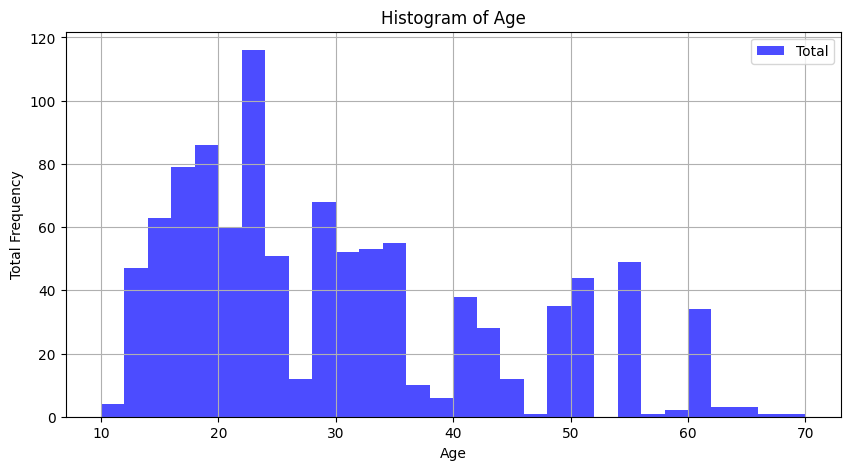

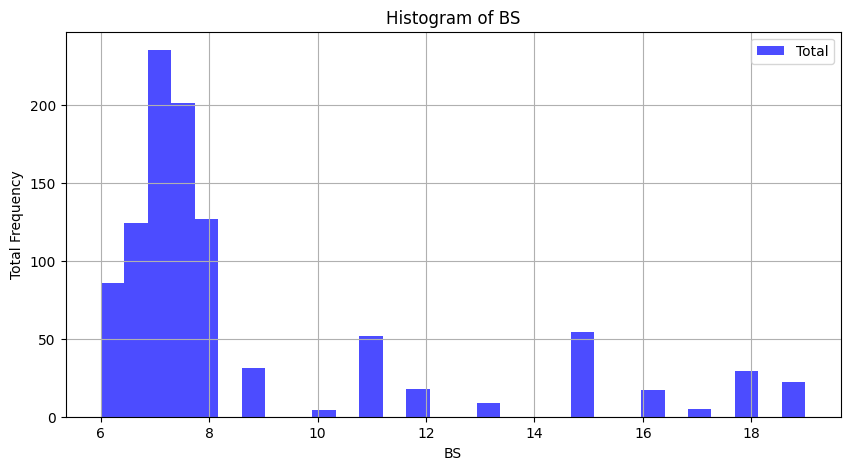

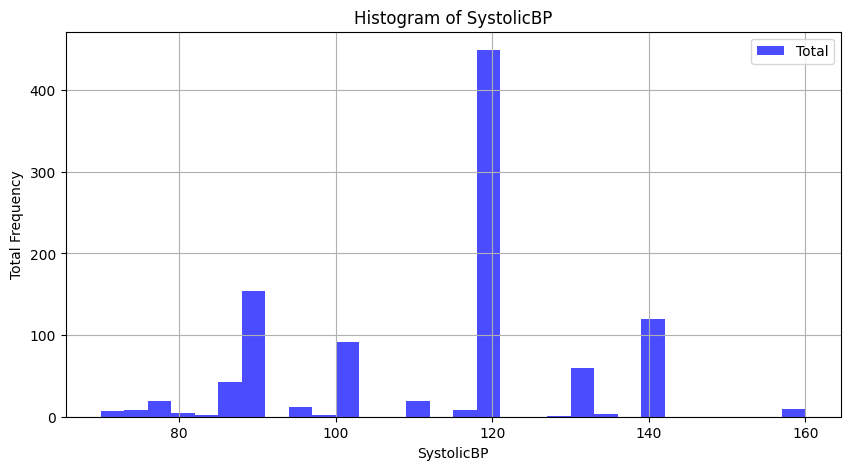

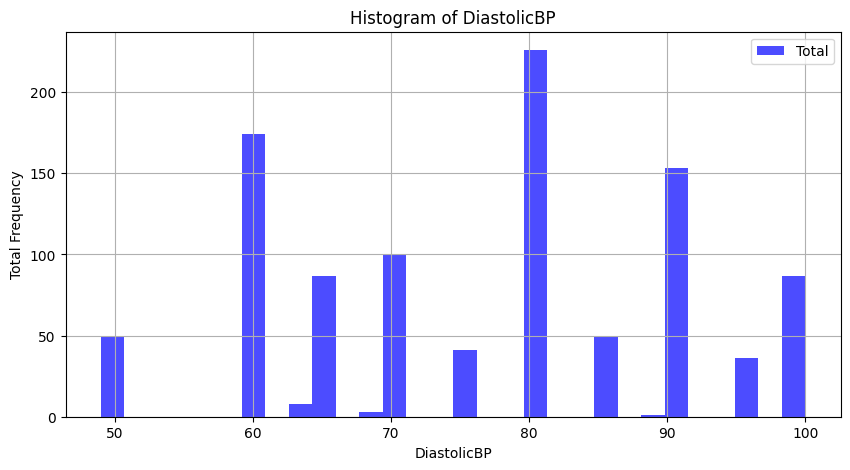

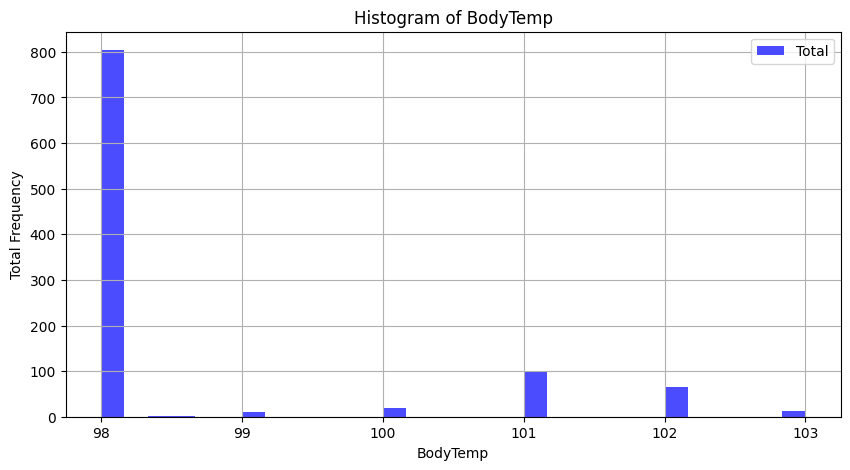

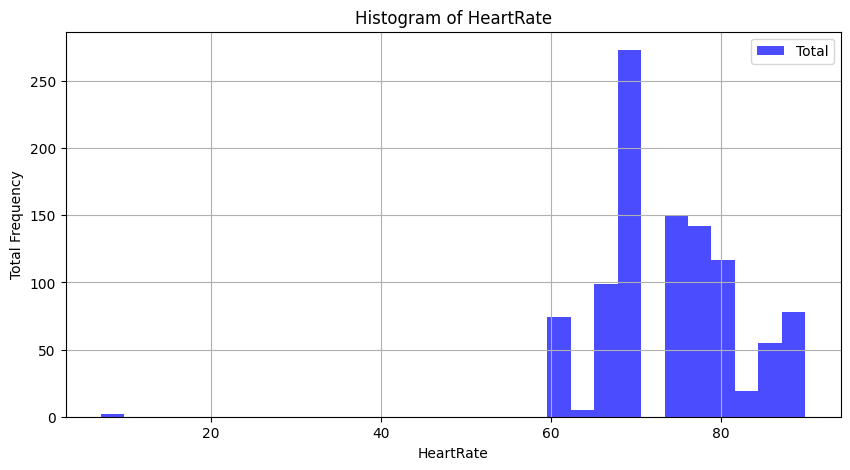

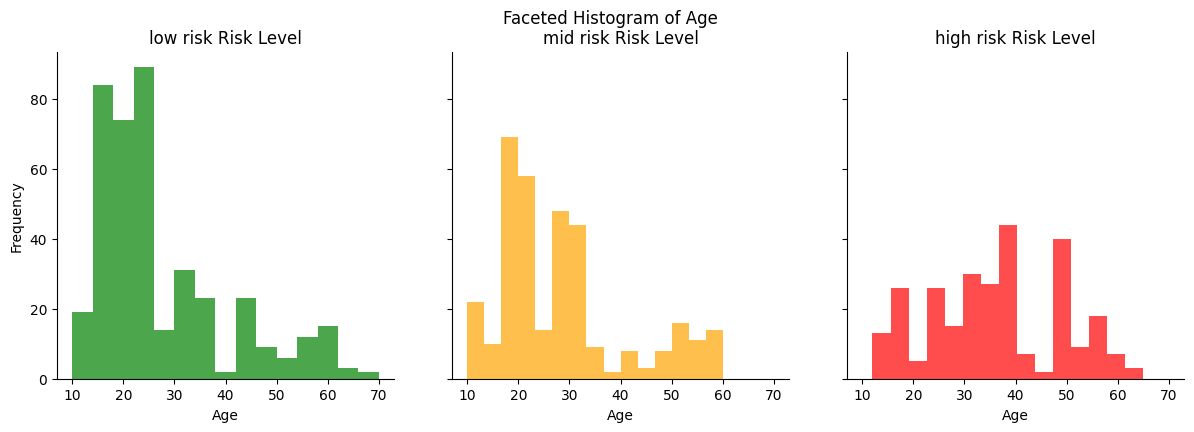

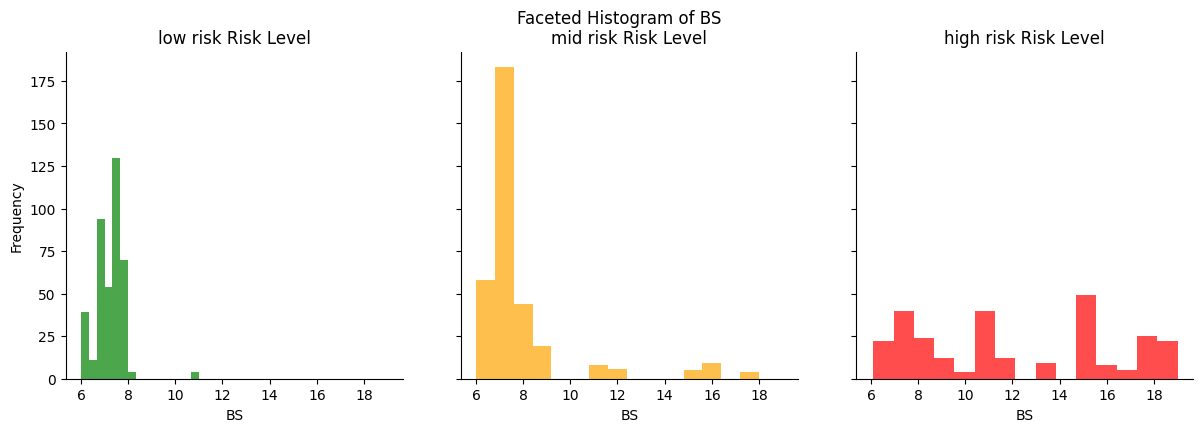

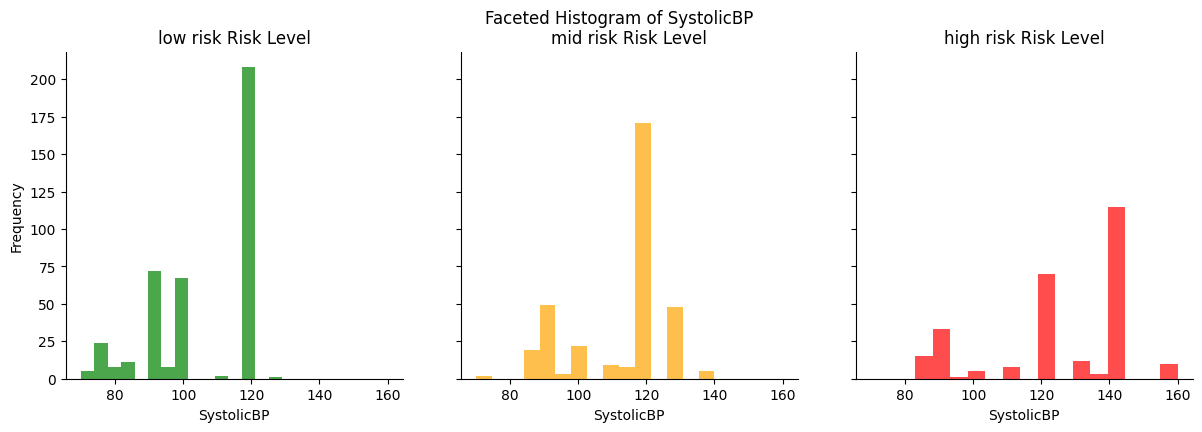

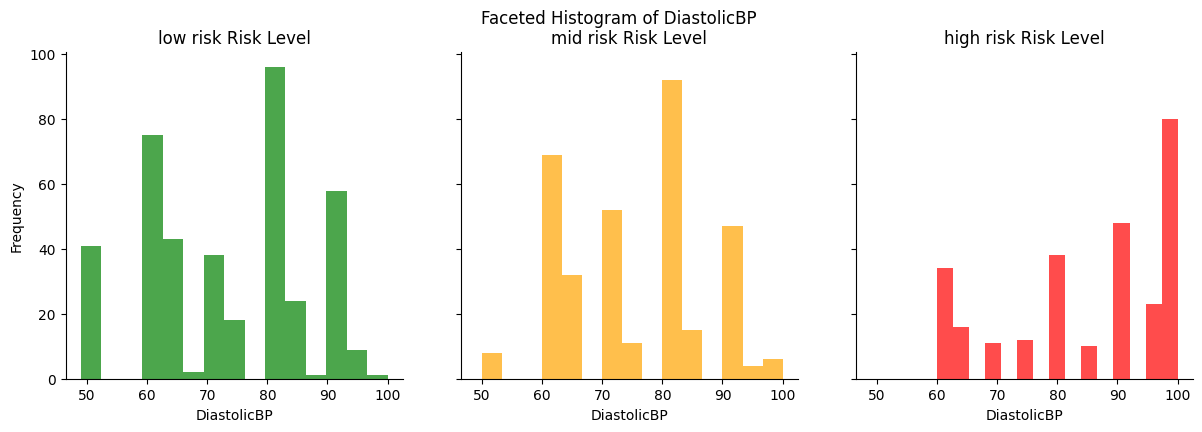

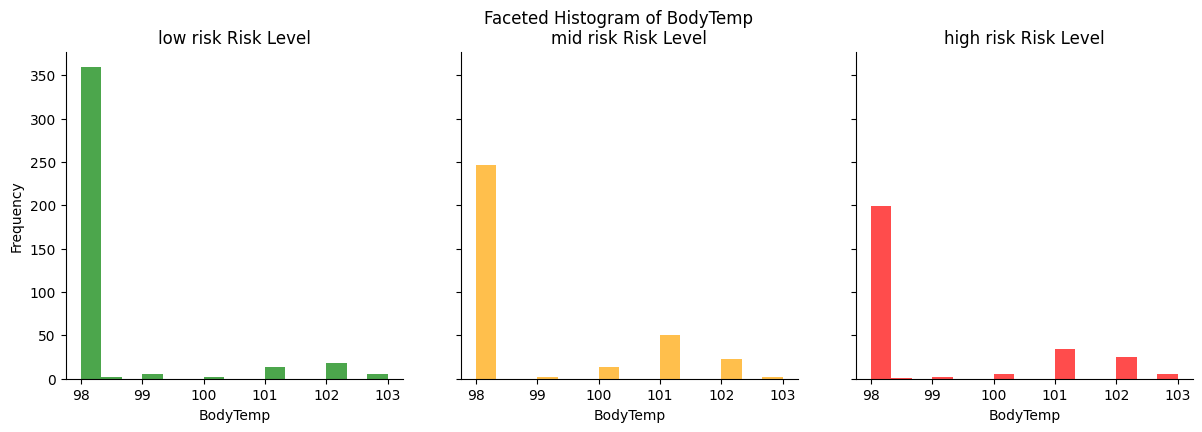

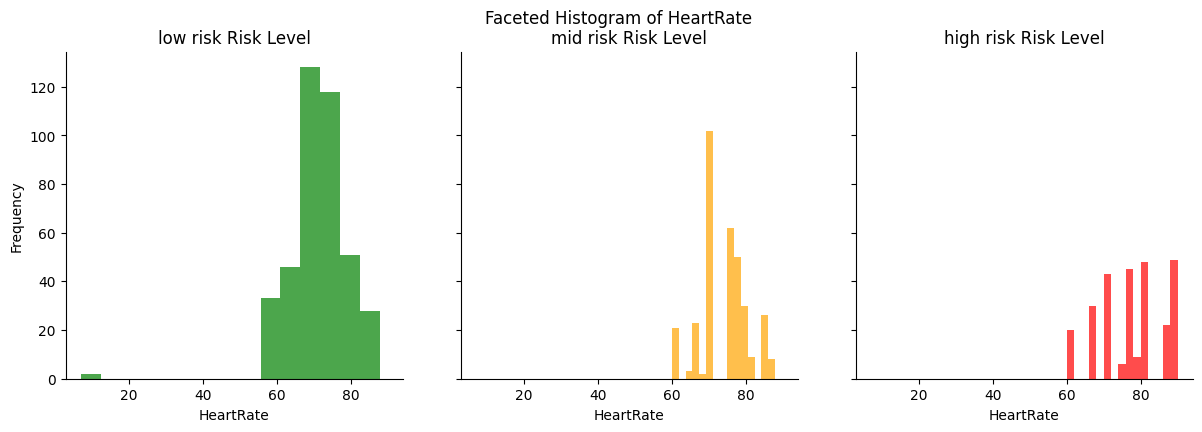

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Count of each category
risk_counts = data['RiskLevel'].value_counts()
print(f"Low risk patients: {risk_counts.get('low risk', 0)}")
print(f"Mid risk patients: {risk_counts.get('mid risk', 0)}")
print(f"High risk patients: {risk_counts.get('high risk', 0)}")

# Features to plot histograms for
hist_features = ['Age', 'BS', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'HeartRate']

# Plotting simple histograms for all features
for feature in hist_features:
    plt.figure(figsize=(10, 5))
    plt.hist(data[feature], bins=30, alpha=0.7, color='blue', label='Total')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Total Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()

# Ensuring RiskLevel order is Low, Mis, High
data['RiskLevel'] = pd.Categorical(data['RiskLevel'], categories=['low risk', 'mid risk', 'high risk'], ordered=True)

# Plotting faceted histograms by Risk Leve
for feature in hist_features:

    g = sns.FacetGrid(data, col="RiskLevel", sharex=True, sharey=True, col_wrap=3, height=4)

    # Colors
    risk_colors = {'low risk': 'green', 'mid risk': 'orange', 'high risk': 'red'}

    # Plot histograms
    for ax, level in zip(g.axes.flat, data['RiskLevel'].cat.categories):
        subset = data[data['RiskLevel'] == level]
        ax.hist(subset[feature], bins=15, alpha=0.7, color=risk_colors[level])
        ax.set_title(f"{level} Risk Level")

    # Set overall axis labels and title
    g.set_axis_labels(feature, "Frequency")
    g.fig.suptitle(f'Faceted Histogram of {feature}', y=1.02)

    plt.show()


**Visual Trends:**

High Risk population seems to have higher blood sugar, systolic pressure, and diastolic pressure.

There seems to be a weaker postive correlation with body temperature and age but not as clear.

We have 272 low risk cases, lower than the other category amounts but close.

**Outliers Noticed:**

1. There are about 2 extremely low (~10 bpm) cases. We should remove these in pre-processing due to them being extreme cases or potentially inaccurate measurements.


> "When your resting heart rate is under 60 bpm, providers call it bradycardia. This means you could have a problem with the signals that tell your heart when to beat... Competitive athletes can have resting heart rates as low as 40 bpm or so. For the average person, however, that rate would be dangerously low." - Cleveland Clinic *https://my.clevelandclinic.org/health/diagnostics/heart-rate*


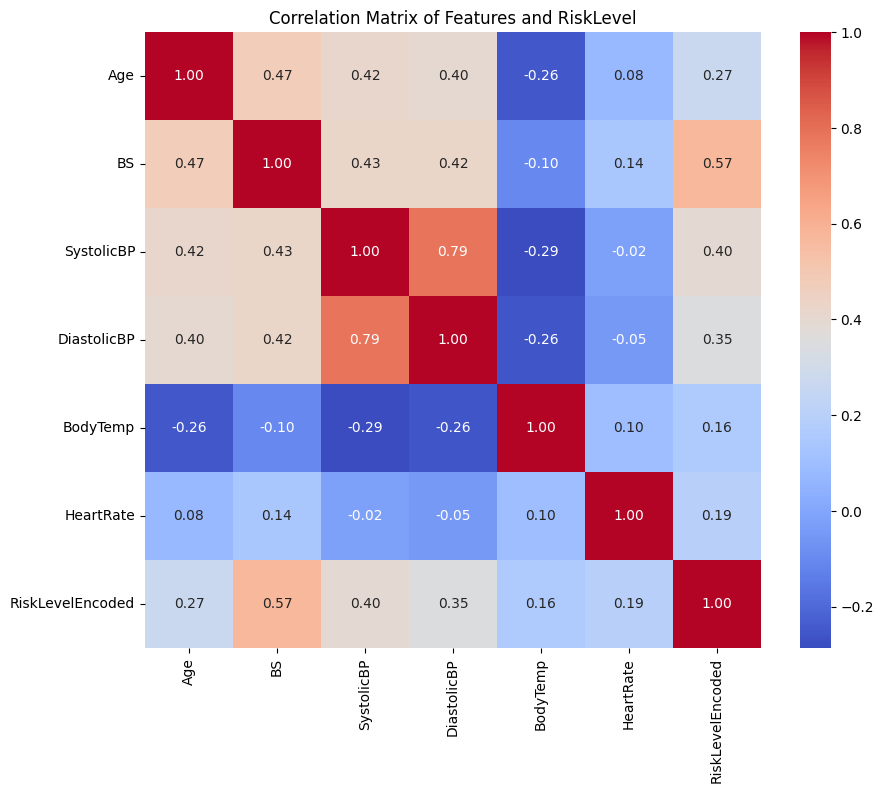

Correlation of Features with RiskLevel:
       Feature  Correlation with RiskLevel
0           BS                    0.569942
1   SystolicBP                    0.396473
2  DiastolicBP                    0.346649
3          Age                    0.267225
4    HeartRate                    0.194312
5     BodyTemp                    0.163984


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encode RiskLevel as numeric for correlation
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
data['RiskLevelEncoded'] = data['RiskLevel'].map(risk_mapping)

# Features to analyze
features = ['Age', 'BS', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'HeartRate']

# Calculate correlation matrix for numerical features
correlation_matrix = data[features + ['RiskLevelEncoded']].corr()

# Display correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix of Features and RiskLevel")
plt.show()

# Extract correlations with RiskLevel
correlation_with_risk = correlation_matrix['RiskLevelEncoded'].drop('RiskLevelEncoded')

# Display correlations with RiskLevel
correlation_df = correlation_with_risk.sort_values(ascending=False).reset_index()
correlation_df.columns = ['Feature', 'Correlation with RiskLevel']
print("Correlation of Features with RiskLevel:")
print(correlation_df)


**Takeaways**

The correlation values match with the visual analysis and offer more clarity.
BS has the highest correlation value ~0.57. It may prove to be the most predictive feature and the difference seems significant. Both blood pressures are also highly correlated. Age, HeartRate, and BodyTemp show correlations but they are smaller. Lets try to visualize these a different way to see if it becomes more apparent.



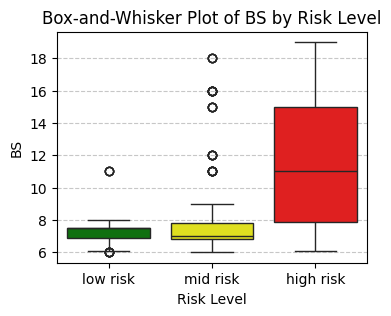

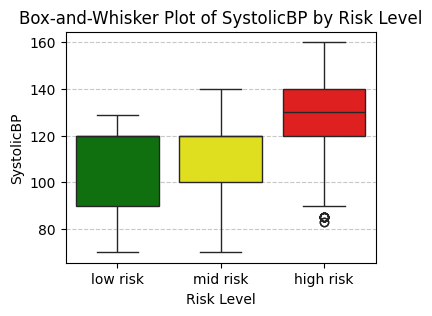

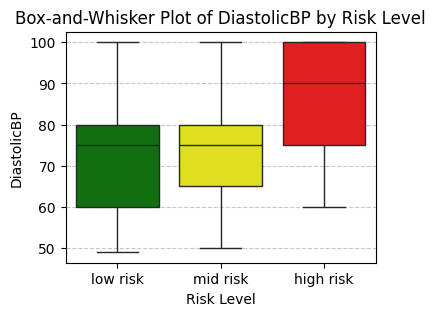

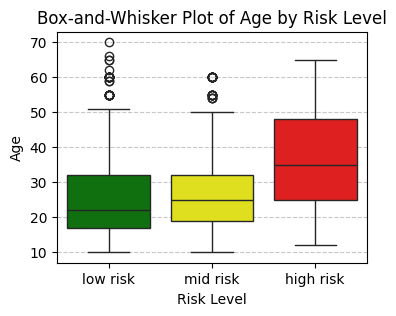

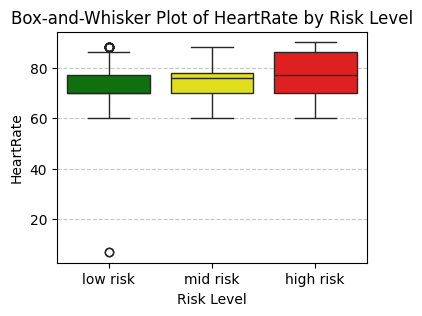

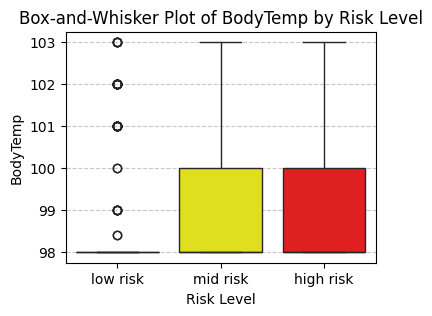

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features ranked by correlation
features = ['BS', 'SystolicBP', 'DiastolicBP', 'Age', 'HeartRate' , 'BodyTemp']

# Loop through each feature and create a boxplot
for feature in features:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=data, x='RiskLevel', y=feature, hue='RiskLevel', palette={'low risk': 'green', 'mid risk': 'yellow', 'high risk': 'red'}, dodge=False, legend=False)

    # Set plot title and labels
    plt.title(f"Box-and-Whisker Plot of {feature} by Risk Level")
    plt.xlabel("Risk Level")
    plt.ylabel(feature)

    # Display the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


**Visual Trend**

Correlations were expressed clearly in BS, and blood pressures as expected. This can be seen visually as the mean values increase as risk increases.

Although body temperature had the lowest correlation score, the wisker plots across risk levels seem very different. It may be that risk level is associated with higher variance of body temperature. I wonder how we can use this information.



**Exploring Engineered Features**

I spoke to my brother who is a medical student and he suggested to investigate Mean Arterial Pressure and Pulse Pressure. These are calculated from Systolic and Diastolic Pressures.

1. MAP= (SystolicBP + 2 * DiastolicBP) / 3
2. Pulse Pressure = SystolicBP - DiastolicBP

I thought to subtract body temperature from the lowest observed body temperature to magnify the differences between low and high temperature. The difference between 98 and 103 degrees is significant medically but it is not demonstrated in relative measurement.

3. Temperature Deviation = BodyTemp - 98


Correlation of Derived Features with RiskLevel:
        Feature  Correlation with RiskLevel
0            BS                    0.569942
1    SystolicBP                    0.396473
2           MAP                    0.386787
3   DiastolicBP                    0.346649
4           Age                    0.267225
5            PP                    0.218397
6     HeartRate                    0.194312
7  Temp_Anomaly                    0.163984
8      BodyTemp                    0.163984


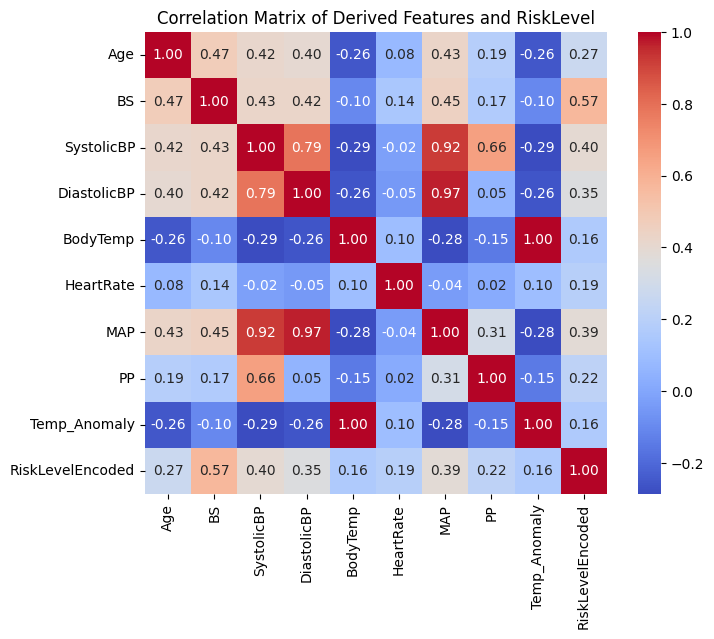

In [ ]:
import pandas as pd
import numpy as np

# Define the features for calculation
features = ['Age', 'BS', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'HeartRate']

# 1. Mean Arterial Pressure (MAP)
data['MAP'] = (data['SystolicBP'] + 2 * data['DiastolicBP']) / 3

# 2. Pulse Pressure (PP)
data['PP'] = data['SystolicBP'] - data['DiastolicBP']

# 3. Temperature Anomaly
# Convert normal temperature (37°C) to Fahrenheit
normal_temp_fahrenheit = 98.6  # 37°C in Fahrenheit
data['Temp_Anomaly'] = data['BodyTemp'] - normal_temp_fahrenheit

# 4. Correlation Analysis
# Encode RiskLevel as numeric for correlation
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
data['RiskLevelEncoded'] = data['RiskLevel'].map(risk_mapping)

# Calculate correlations for new features with RiskLevel
derived_features = ['MAP', 'PP', 'Temp_Anomaly']
correlation_matrix = data[features + derived_features + ['RiskLevelEncoded']].corr()

# Extract correlations with RiskLevel
correlation_with_risk = correlation_matrix['RiskLevelEncoded'].drop('RiskLevelEncoded')

# Display correlations
correlation_df = correlation_with_risk.sort_values(ascending=False).reset_index()
correlation_df.columns = ['Feature', 'Correlation with RiskLevel']

print("Correlation of Derived Features with RiskLevel:")
print(correlation_df)

# Visualize correlations using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Derived Features and RiskLevel")
plt.show()


**Correlation Analysis of Engineered Features**

Engineered features have slightly lower correlations to risk level than the features they are derived from. However, it remains to be seen in training how these features may affect the model.

**Pre-processing goals**

1. Remove extremely low heart rate values that are outliers.

2. Reorder risk level to low risk, mid risk, high risk.

3. Add engineered features Mean Arterial Pressure (MAP), Pulse Pressure (PP), and Temperature Difference (Temp_Diff).

In [ ]:
# Load the dataset
data = pd.read_csv('maternal_health_risk.csv')

# Define a threshold for extreme low heart rate values
low_threshold = 40

# Filter the dataset to exclude rows with extreme low heart rate and create a copy
filtered_data = data[data['HeartRate'] > low_threshold].copy()

# Ordering RiskLevel
filtered_data['RiskLevel'] = pd.Categorical(
    filtered_data['RiskLevel'],
    categories=['low risk', 'mid risk', 'high risk'],
    ordered=True
)

# Mean Arterial Pressure (MAP)
filtered_data['MAP'] = (filtered_data['SystolicBP'] + 2 * filtered_data['DiastolicBP']) / 3

# Pulse Pressure (PP)
filtered_data['PP'] = filtered_data['SystolicBP'] - filtered_data['DiastolicBP']

# Temperature Anomaly (using Fahrenheit)
normal_temp_fahrenheit = 98  # Minimum measured body temperature in Fahrenheit
filtered_data['Temp_Diff'] = filtered_data['BodyTemp'] - normal_temp_fahrenheit

# Statistical Summary
print("Statistical Summary for Filtered Data:")
stats_summary = filtered_data.describe()
print(stats_summary)

# Save the processed dataset to a new CSV file
output_file = 'processed_m_h_r.csv'
filtered_data.to_csv(output_file, index=False)
print(f"\nProcessed data saved to {output_file}")


Statistical Summary for Filtered Data:
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1012.000000  1012.000000  1012.000000  1012.000000  1012.000000   
mean     29.899209   113.184783    76.463439     8.727619    98.666403   
std      13.473560    18.419618    13.899372     3.296583     1.372421   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate          MAP           PP    Temp_Diff  
count  1012.000000  1012.000000  1012.000000  1012.000000  
mean     74.434783    88.703887    36.721344     0.666403  
std       7.521857    14.599125    11.375239     1.372421  
min      60.000000    56.666667     8.000000     0.000

**How to Use - Preprocessing Step**

1. Ensure maternal_health_risk is downloaded within the project directory.

2. Run the pre-processing code block above.

3. It should be named "processed_m_h_r" and be located within the project directory.

4. When running the "Maternal Health_Modeling" notebook it should read without problems.